# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

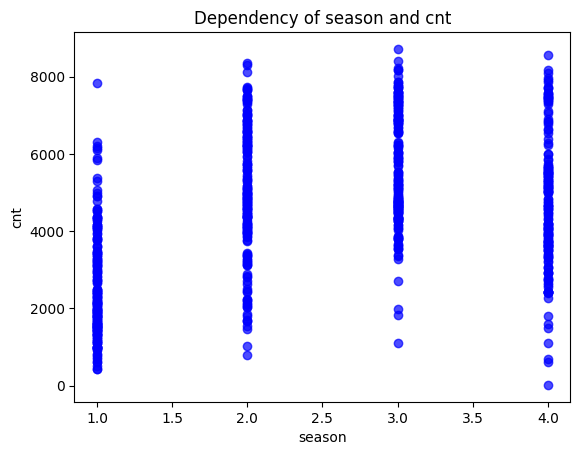

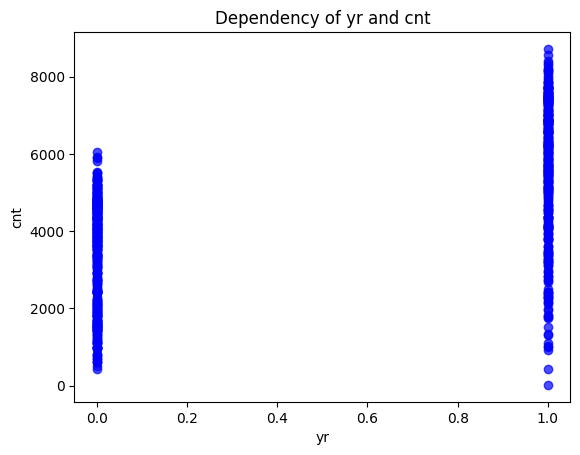

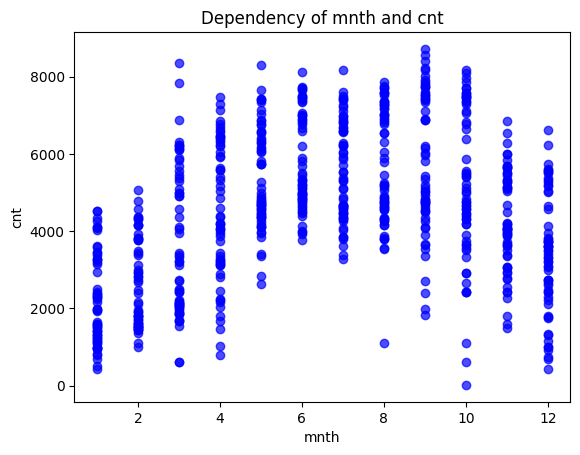

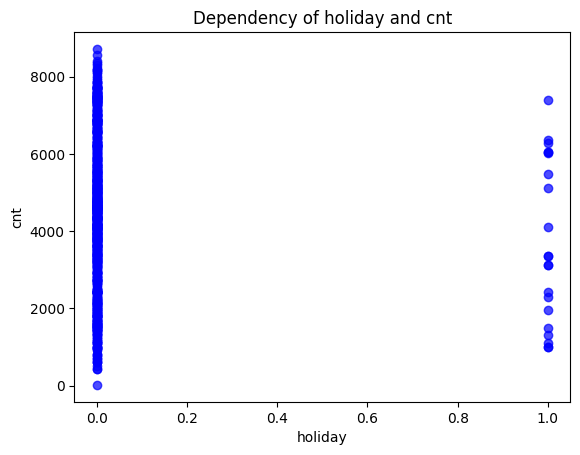

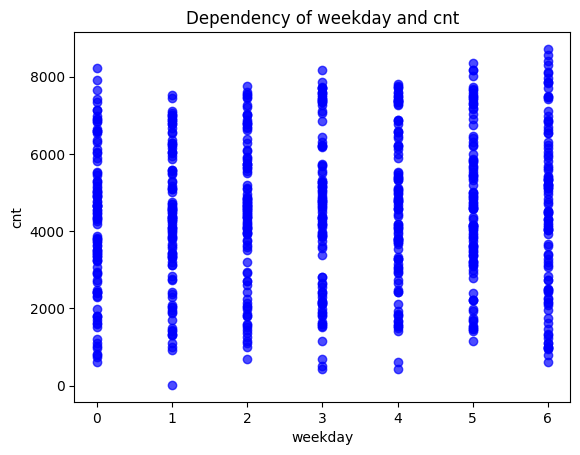

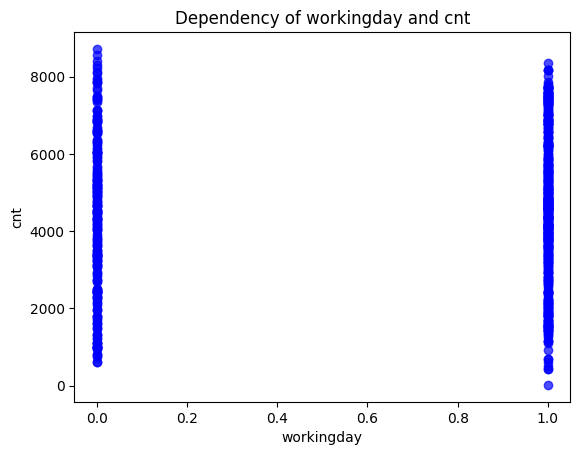

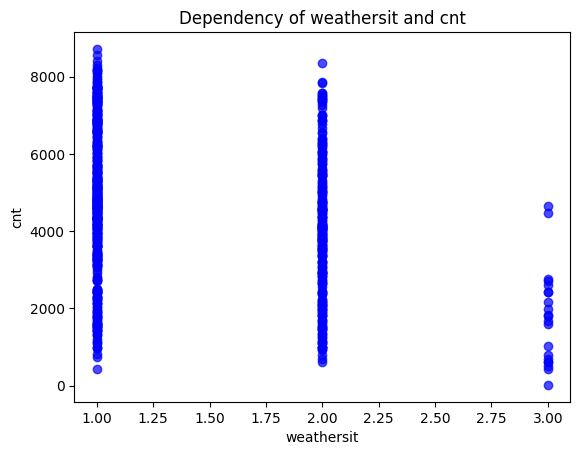

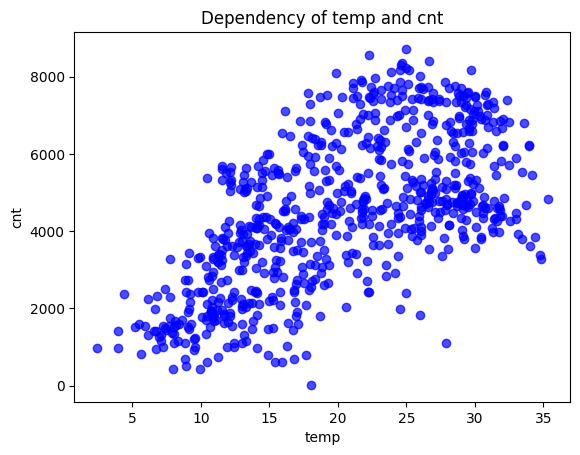

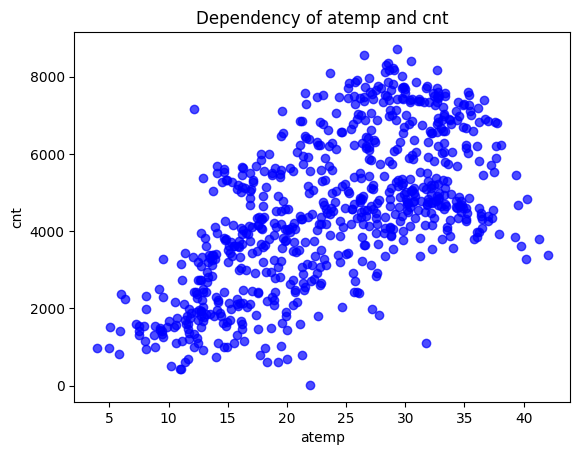

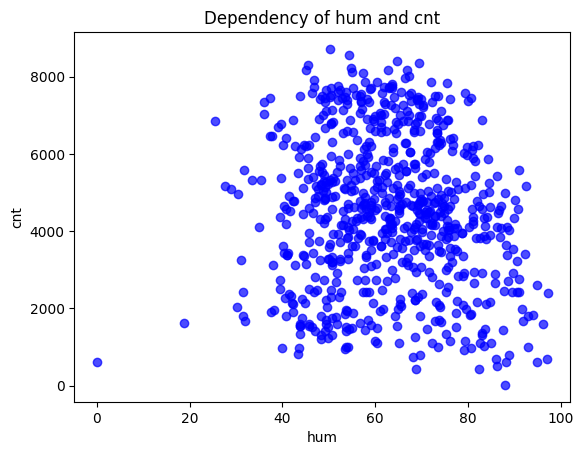

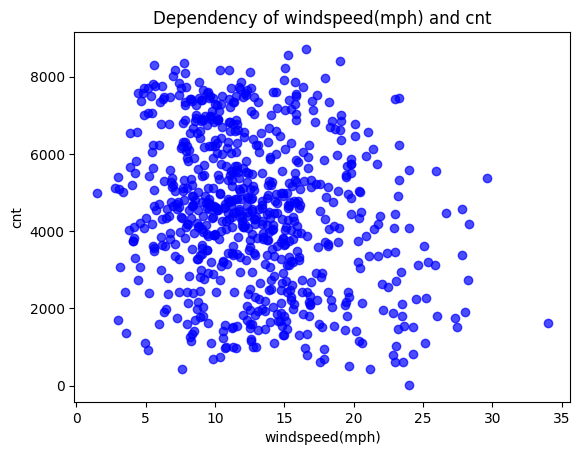

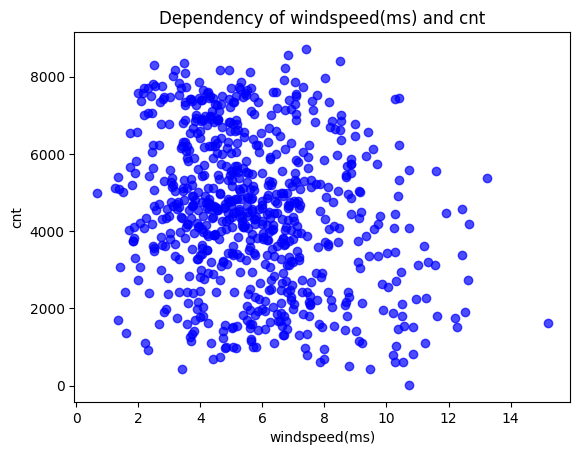

In [3]:
for label in df.columns[:-1]:
  plt.scatter(df[label],df['cnt'],color = 'blue', alpha=0.7)
  plt.title(f"Dependency of {label} and cnt")
  plt.ylabel("cnt")
  plt.xlabel(label)
  plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

In [4]:
print("Яким є характер залежності кількості прокатів від місяця?")
print("Seasonal dependency, as from the peaks appearing in the graph the demand for bike rentals is much higher during warmer months.")
print(f"Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно: {df.columns[7]}, {df.columns[8]}")

Яким є характер залежності кількості прокатів від місяця?
Seasonal dependency, as from the peaks appearing in the graph the demand for bike rentals is much higher during warmer months.
Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно: temp, atemp


## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [5]:
correlations = df.iloc[:, :-1].corrwith(df.iloc[:,-1])
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [6]:
columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
correlations = df[columns].corr()
print(correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [7]:
mean_values = df.mean()
print(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [11]:
X = df_shuffled.drop(columns ='cnt')
y = df_shuffled['cnt']
regressor = LinearRegression()
regressor.fit(X, y)
coefficients = regressor.coef_
for feature, coef in zip(df_shuffled.columns[:-1], coefficients):
  print(f"Feauture \"{feature}\" weight: {coef.round(4)}.")

Feauture "season" weight: 514.2757.
Feauture "yr" weight: 2043.9377.
Feauture "mnth" weight: -40.9626.
Feauture "holiday" weight: -519.3768.
Feauture "weekday" weight: 68.4955.
Feauture "workingday" weight: 121.2945.
Feauture "weathersit" weight: -606.4579.
Feauture "temp" weight: 48.9988.
Feauture "atemp" weight: 71.9117.
Feauture "hum" weight: -10.2303.
Feauture "windspeed(mph)" weight: 2400161678950.119.
Feauture "windspeed(ms)" weight: -5369161675896.219.


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [12]:
from sklearn.linear_model import Lasso

X = df_shuffled.drop(columns ='cnt')
y = df_shuffled['cnt']
lasso_model = Lasso()
lasso_model.fit(X, y)

coefficients = lasso_model.coef_
for feature, coef in zip(df_shuffled.columns[:-1], coefficients):
  print(f"Feauture \"{feature}\" weight: {coef.round(4)}.")

Feauture "season" weight: 506.5513.
Feauture "yr" weight: 2036.2317.
Feauture "mnth" weight: -38.0783.
Feauture "holiday" weight: -484.6519.
Feauture "weekday" weight: 68.9384.
Feauture "workingday" weight: 118.4476.
Feauture "weathersit" weight: -604.5667.
Feauture "temp" weight: 51.3633.
Feauture "atemp" weight: 69.9127.
Feauture "hum" weight: -10.3527.
Feauture "windspeed(mph)" weight: -38.3411.
Feauture "windspeed(ms)" weight: -0.0.


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [13]:
from sklearn.linear_model import Ridge

X = df_shuffled.drop(columns ='cnt')
y = df_shuffled['cnt']
ridge_model = Ridge()
ridge_model.fit(X, y)

coefficients = ridge_model.coef_
for feature, coef in zip(df_shuffled.columns[:-1], coefficients):
  print(f"Feauture \"{feature}\" weight: {coef.round(4)}.")

Feauture "season" weight: 507.8019.
Feauture "yr" weight: 2029.0891.
Feauture "mnth" weight: -38.4709.
Feauture "holiday" weight: -493.278.
Feauture "weekday" weight: 69.114.
Feauture "workingday" weight: 121.5244.
Feauture "weathersit" weight: -605.2056.
Feauture "temp" weight: 49.3168.
Feauture "atemp" weight: 71.786.
Feauture "hum" weight: -10.3834.
Feauture "windspeed(mph)" weight: -31.9355.
Feauture "windspeed(ms)" weight: -14.276.


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)
X = df_shuffled.drop(columns='cnt')
y = df_shuffled['cnt']

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regression = Lasso(alpha=alpha)
    lasso_regression.fit(X, y)
    coefs_lasso.append(lasso_regression.coef_)

for alpha in alphas:
    ridge_regression = Ridge(alpha=alpha)
    ridge_regression.fit(X, y)
    coefs_ridge.append(ridge_regression.coef_)


coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print(f"Lasso coeffiecients: {coefs_lasso}")
print(f"Ridge coeffiecients: {coefs_ridge}")

Lasso coeffiecients: [[ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
   118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
   -38.34106761   -0.        ]
 [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
     0.         -291.33521188   44.34993053   83.88557181  -18.81320743
   -43.35682101   -0.        ]
 [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
     0.           -0.           37.46764176   95.93389064  -26.48659474
   -48.19495616   -0.        ]
 [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
     0.           -0.           33.15169023  102.54337981  -26.88669007
   -47.85305889   -0.        ]
 [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
     0.           -0.           27.55035178  110.33369233  -27.29091458
   -47.46769509   -0.        ]
 [   0.          994.19323854   73.37527257   -0.            0.
     0.           -0.           21.7063142

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

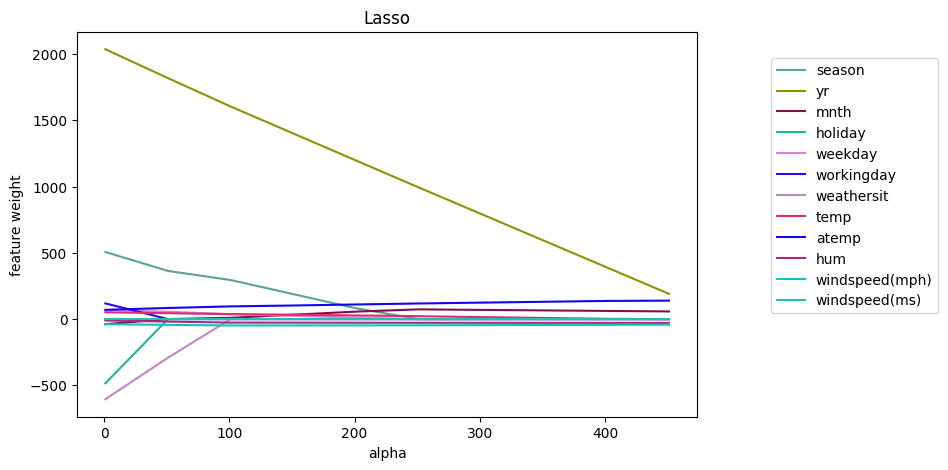

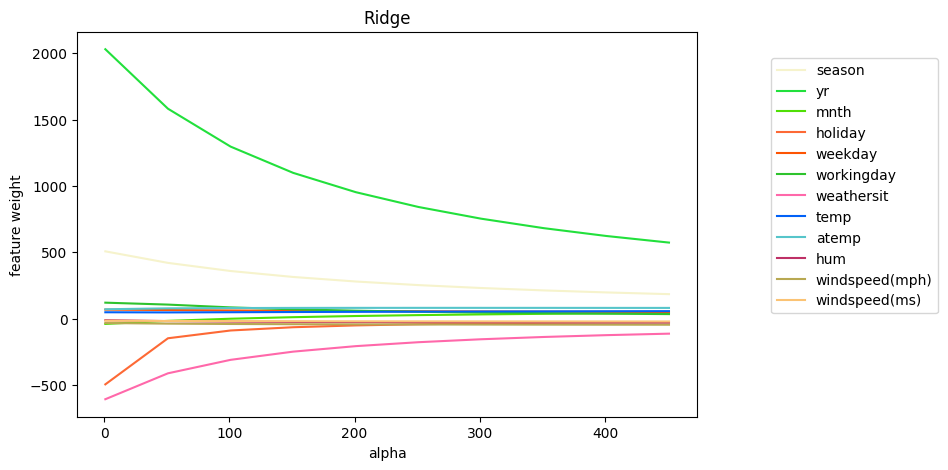

In [15]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

In [16]:
print("1) Lasso.")
print("2) In case of alpha value being increased way too much, the weights will be reduced to 0.")
print("Because of L1-regulation, the model will try to minimize the loss in terms of nearly eliminating the coefficients.")
print("3) Lasso can exclude the windspread by setting the weights to zero (or closely) for certain alpha values.")
print("While Ridge, using L2-norm regularization, only reduces coefficient sizes without removing features entirely.")
print("4) Lasso will be the better choice in terms of non_informative features, as it sets the cofficients while removing those features from the model. ")

1) Lasso.
2) In case of alpha value being increased way too much, the weights will be reduced to 0.
Because of L1-regulation, the model will try to minimize the loss in terms of nearly eliminating the coefficients.
3) Lasso can exclude the windspread by setting the weights to zero (or closely) for certain alpha values.
While Ridge, using L2-norm regularization, only reduces coefficient sizes without removing features entirely.
4) Lasso will be the better choice in terms of non_informative features, as it sets the cofficients while removing those features from the model. 


### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [17]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e+06, tolerance: 2.458e+05
  model = cd_fast.enet_coordinate_descent(


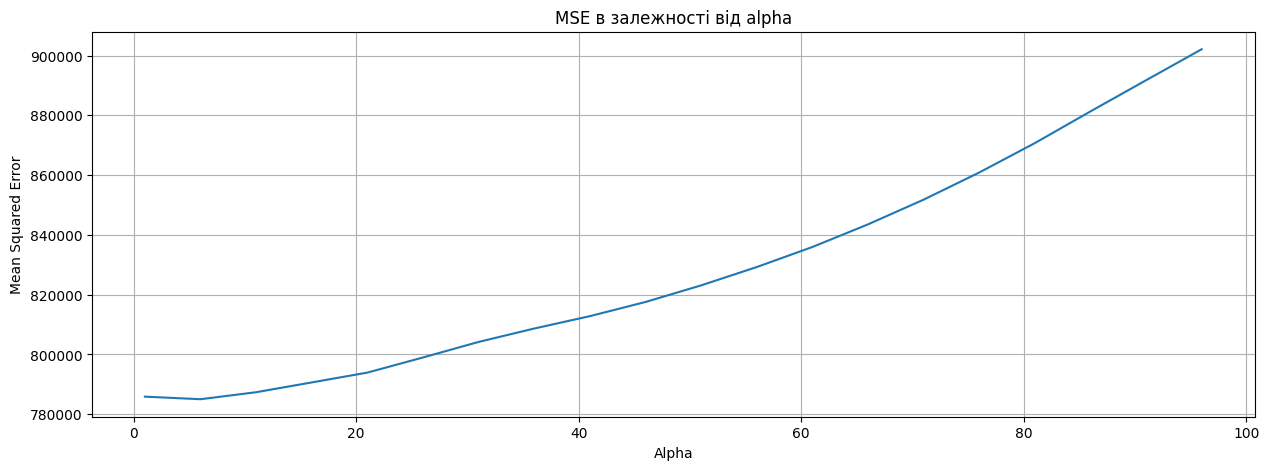

Alpha: 6
           feature  coefficient
0           season   490.330160
1               yr  2014.000212
2             mnth   -33.552638
3          holiday  -311.108548
4          weekday    68.529521
5       workingday   109.156720
6       weathersit  -571.822739
7             temp    52.576805
8            atemp    69.666198
9              hum   -11.215645
10  windspeed(mph)   -38.917715
11   windspeed(ms)    -0.000000


In [18]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

alphas = np.arange(1, 100, 5)

X = df_shuffled.drop(columns='cnt')
y = df_shuffled['cnt']

regressor = LassoCV(alphas=alphas, cv=10)
regressor.fit(X, y)
selected_alpha = regressor.alpha_

mean_mse = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    mse = -np.mean(cross_val_score(lasso, X, y, scoring="neg_mean_squared_error", cv=10))
    mean_mse.append(mse)

plot_data = list(zip(alphas, mean_mse))
create_plot(plot_data, "MSE в залежності від alpha", "Alpha", "Mean Squared Error")

print(f"Alpha: {selected_alpha}")

lasso_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': regressor.coef_
})

print(lasso_coef)


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alphas with minimum MSE:
Alpha = 96, MSE = 631712.6742365923
Alpha = 96, MSE = 762168.529834473
Alpha = 86, MSE = 796322.304486868
Alpha = 76, MSE = 935325.7504397706
Alpha = 96, MSE = 580502.8424978638
Alpha = 86, MSE = 817807.7604947224
Alpha = 76, MSE = 741876.2615646209
Alpha = 96, MSE = 991302.18934488
Alpha = 86, MSE = 972395.1589440213
Alpha = 96, MSE = 539731.3979493112


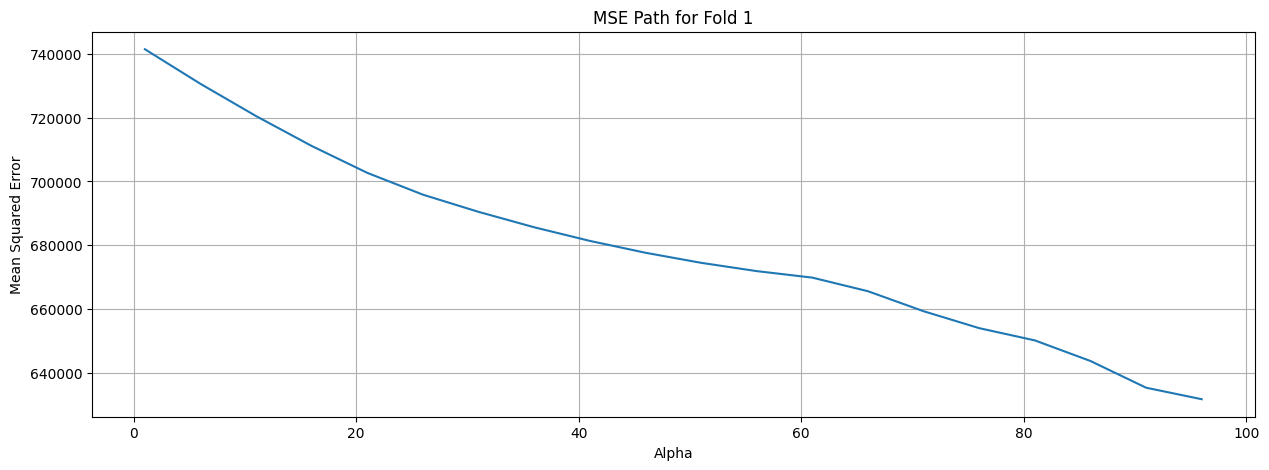

Minimum MSE for Fold 1: Alpha = 96, MSE = 631712.6742365923


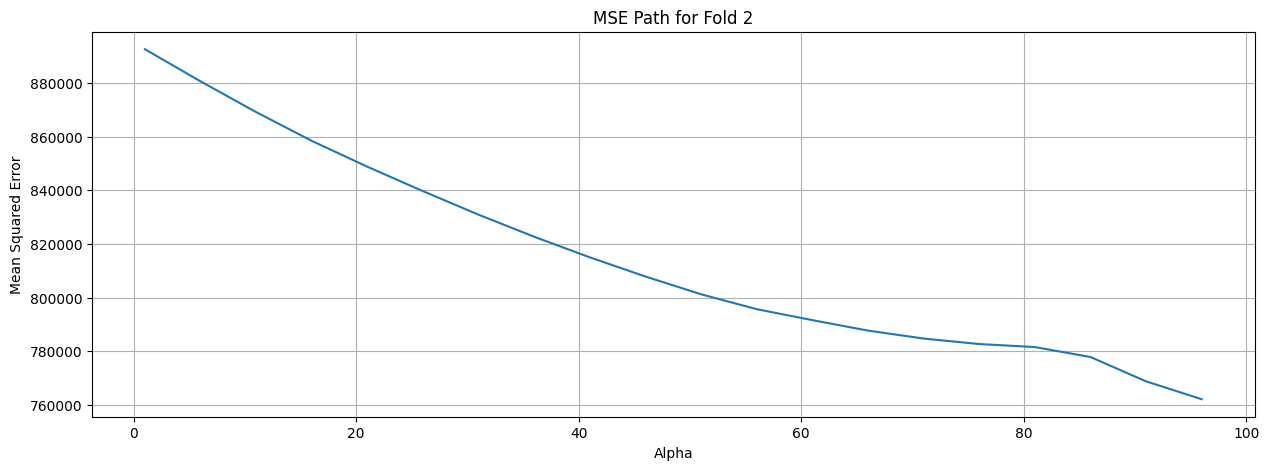

Minimum MSE for Fold 2: Alpha = 96, MSE = 762168.529834473


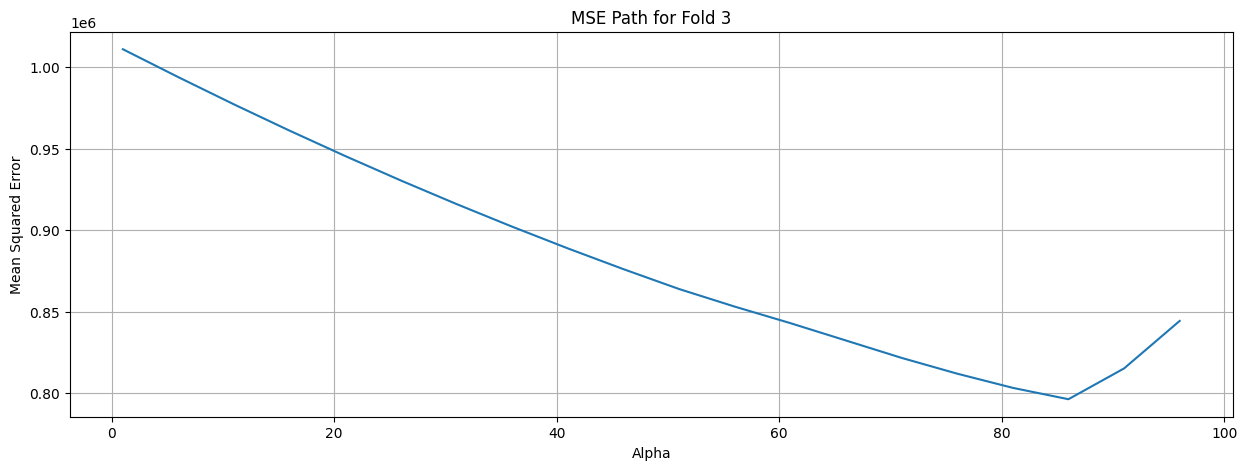

Minimum MSE for Fold 3: Alpha = 86, MSE = 796322.304486868


In [19]:
mse_path = regressor.mse_path_

min_mse_indices = np.argmin(mse_path, axis=0)
min_mse_alphas = alphas[min_mse_indices]

print("Alphas with minimum MSE:")
for i, alpha in enumerate(min_mse_alphas):
    print(f"Alpha = {alpha}, MSE = {mse_path[min_mse_indices[i], i]}")

for i in range(3):
    plot_data = list(zip(alphas, mse_path[:, i]))
    create_plot(plot_data, f"MSE Path for Fold {i + 1}", "Alpha", "Mean Squared Error")
    min_alpha = min_mse_alphas[i]
    min_mse = mse_path[min_mse_indices[i], i]
    print(f"Minimum MSE for Fold {i + 1}: Alpha = {min_alpha}, MSE = {min_mse}")

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

In [25]:
print("Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками?")
print("No, we can only observe a slight tendency in the atemp and cnt dependency graph.")
print("Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?")
print("Partially yes, but not in case of all selected features.")

Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками?
No, we can only observe a slight tendency in the atemp and cnt dependency graph.
Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?
Yes, but not in case of all selected features.


__Відповідь:__

      feature  coefficient
1          yr  2014.000212
0      season   490.330160
5  workingday   109.156720
8       atemp    69.666198


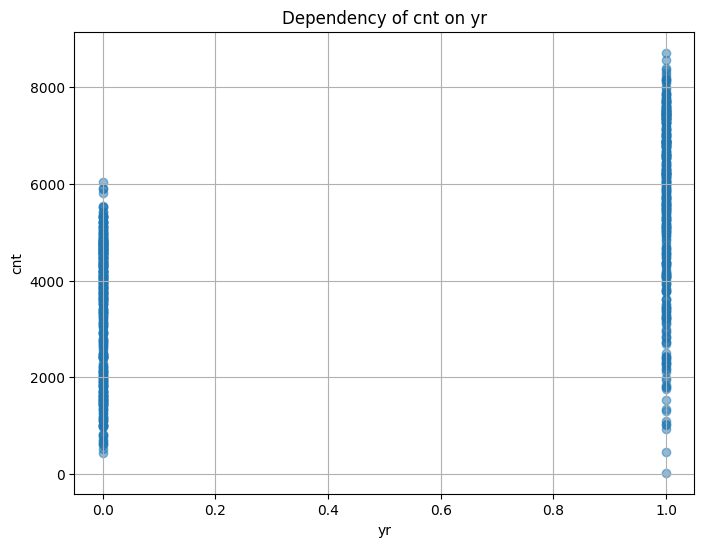

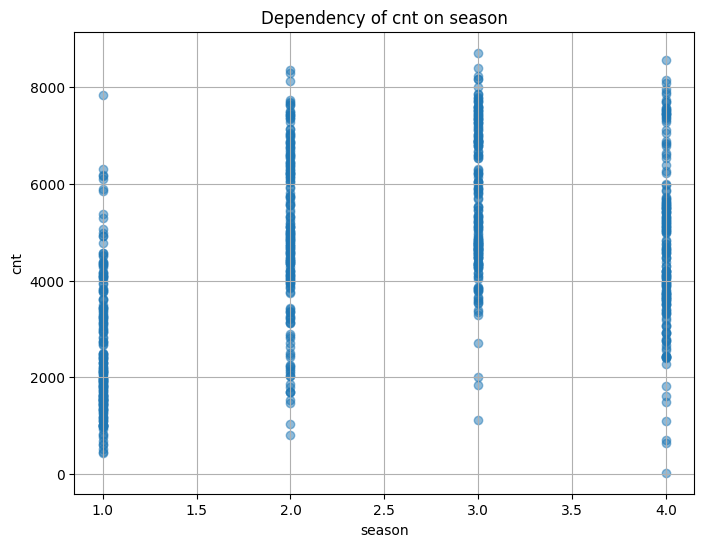

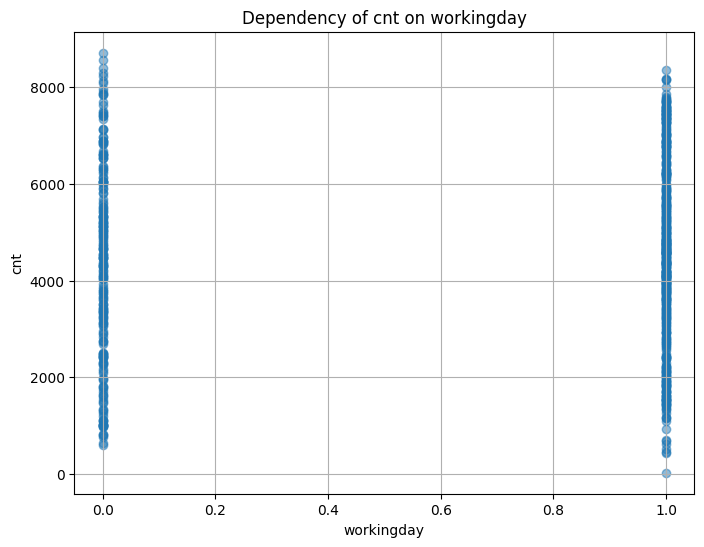

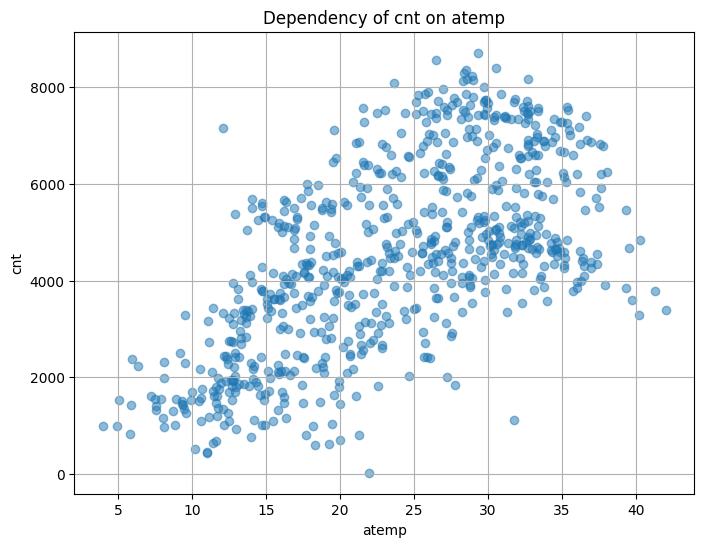

In [23]:
positive_coefs = lasso_coef[lasso_coef['coefficient'] > 0]
top_4_features = positive_coefs.nlargest(4, 'coefficient')

print(top_4_features)

for feature in top_4_features['feature']:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_shuffled[feature], df_shuffled['cnt'], alpha=0.5)
    plt.title(f"Dependency of cnt on {feature}")
    plt.xlabel(feature)
    plt.ylabel("cnt")
    plt.grid(True)
    plt.show()

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

In [26]:
print("Чи видно лінійну залежність, що зменшується?")
print("Not really, only a slight in terms of windspeed, but it has a pretty significant scatter of points.")
print("Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?")
print("Partially yes, but not all selected features.")

Чи видно лінійну залежність, що зменшується?
Not really, only a slight in terms of windspeed, but it has a pretty significant scatter of points.
Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?
Partially yes, but not all selected features.


__Відповідь:__

           feature  coefficient
6       weathersit  -571.822739
3          holiday  -311.108548
10  windspeed(mph)   -38.917715


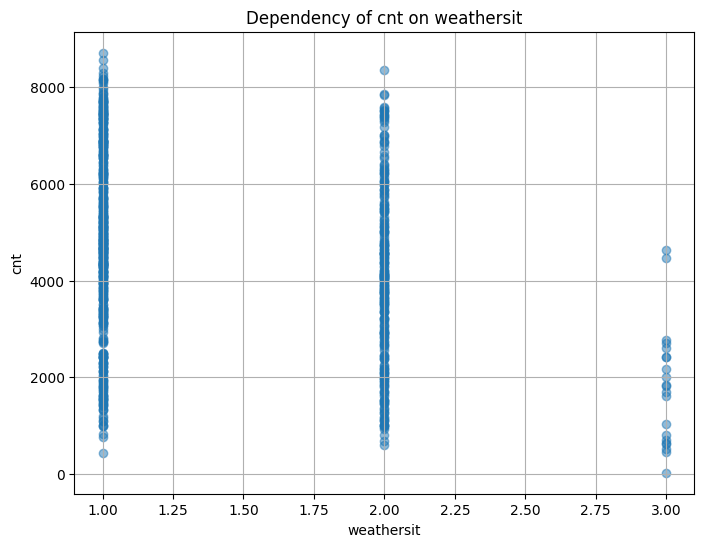

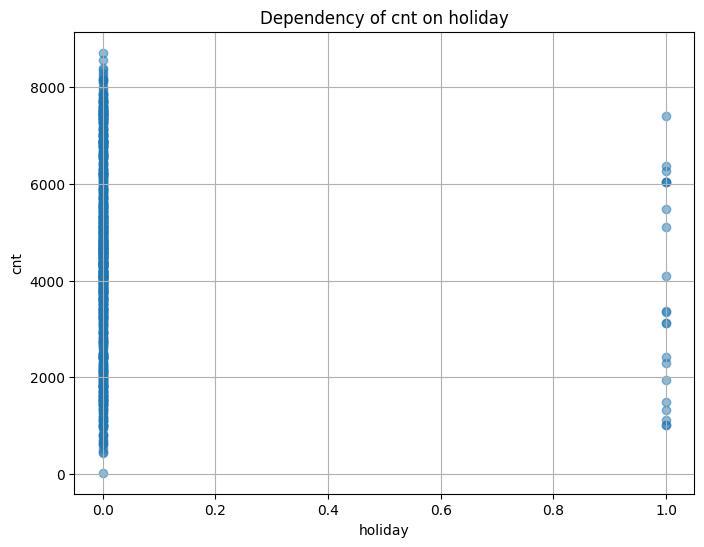

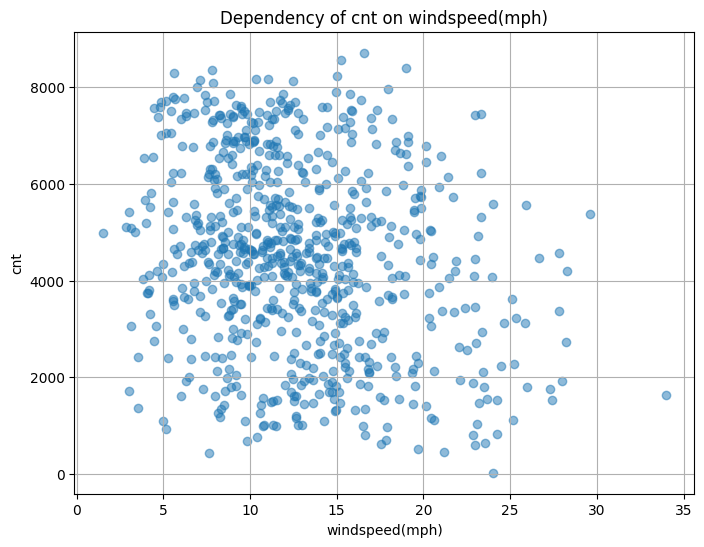

In [24]:
negative_coefs = lasso_coef[lasso_coef['coefficient'] < 0]
top_3_features = negative_coefs.nsmallest(3, 'coefficient')

print(top_3_features)

for feature in top_3_features['feature']:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_shuffled[feature], df_shuffled['cnt'], alpha=0.5)
    plt.title(f"Dependency of cnt on {feature}")
    plt.xlabel(feature)
    plt.ylabel("cnt")
    plt.grid(True)
    plt.show()

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

In [31]:
print("Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)?")
print("Чи правда, що вони ніяк не впливають на попит на велосипеди?")
print("The selected feature's influence on demand is nearly absent. But it is not completely nonexistent.")


Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)?
Чи правда, що вони ніяк не впливають на попит на велосипеди?
The selected feature's influence on demand is nearly absent. But it is not completely nonexistent.


__Відповідь:__

          feature  coefficient
11  windspeed(ms)         -0.0


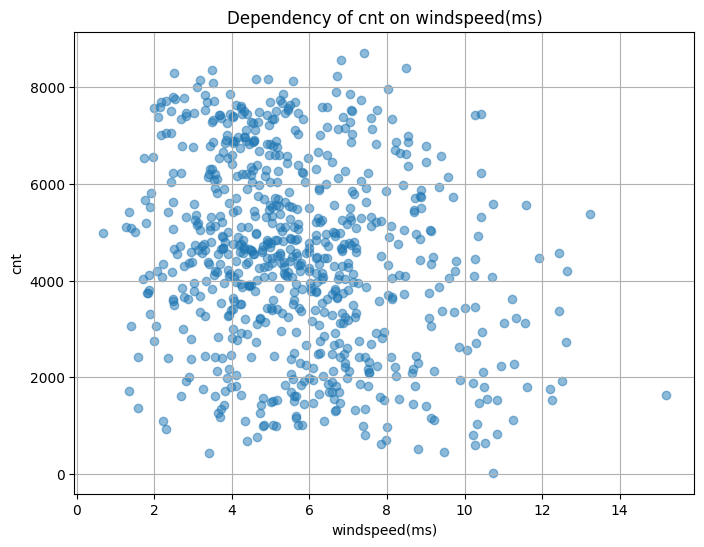

In [28]:
selected_features = lasso_coef[lasso_coef['coefficient'].abs() < 1e-3]
print(selected_features)

for feature in selected_features['feature']:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_shuffled[feature], df_shuffled['cnt'], alpha=0.5)
    plt.title(f"Dependency of cnt on {feature}")
    plt.xlabel(feature)
    plt.ylabel("cnt")
    plt.grid(True)
    plt.show()

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.